# Callin Switzer
### 30 May 2019


# Make videos of tracking moth

___

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import math
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.patches import Arc
from collections import OrderedDict
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import sys
import pandas as pd
import importlib
print(sys.version)
now = datetime.now()
print("last run on " + str(now))

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
last run on 2019-06-18 14:43:21.155410


In [2]:
import numba
numba.__version__

'0.36.2'

In [3]:
import importlib

In [4]:
import simUtils_DLVersion as simUtils


In [5]:
importlib.reload(simUtils)

<module 'simUtils_DLVersion' from 'C:\\Users\\calli\\Documents\\GitRepos\\MothMachineLearning\\simUtils_DLVersion.py'>

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors
from  mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob


# make sure Keras uses CPU instead of GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
else: 
    print("tensorflow using CPU")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\CallinStuff\Presentations\eScience_Community_Seminar_2019'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\PythonGeneratedData\TrainingData'
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
tensorflow using CPU
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-06-18 14:43:23.800582


In [7]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers
from keras.models import load_model

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [8]:
# define some functions

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    '''
    rho: radius
    phi: angle (in radians)
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history_dictionary['val_mean_squared_error'])+1),
                   len(model_history_dictionary['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        plt.ylim([0.000001, 0.05])
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned_2.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))
    plt.show()



In [9]:
from collections import OrderedDict

globalDict = OrderedDict({"bhead": 0.507,
            "ahead": 0.908,
            "bbutt": 0.1295,
            "abutt": 1.7475, 
            "rho": 1, 
            "rhoA": 0.00118, 
            "muA": 0.000186, 
            "L1": 0.908, 
            "L2": 1.7475,  
            "L3": 0.75,
            "K": 29.3,
            "c":  14075.8,
            "g": 980.0,
            "betaR":  0.0,
            "nstep": 30,
            "nrun" : 1  # (max) number of  trajectories.
            })

In [10]:
# Calculated variables
globalDict['m1'] = globalDict['rho']*(4/3)*np.pi*(globalDict['bhead']**2)*globalDict['ahead']
globalDict["m2"] = globalDict["rho"]*(4/3)*np.pi*(globalDict["bbutt"]**2)*globalDict["abutt"]
globalDict["echead"] = globalDict["ahead"]/globalDict["bhead"]
globalDict['ecbutt'] = globalDict['abutt']/globalDict['bbutt']
globalDict['I1'] = (1/5)*globalDict['m1']*(globalDict['bhead']**2)*(1 + globalDict['echead']**2)
globalDict['I2'] = (1/5)*globalDict['m2']*(globalDict['bbutt']**2)*(1 + globalDict['ecbutt']**2)
globalDict['S_head'] = np.pi*globalDict['bhead']**2
globalDict['S_butt'] = np.pi*globalDict['bbutt'] **2
t = np.linspace(0, 0.02, num = globalDict["nstep"], endpoint = True)

# convert dict to list, since @jit works better with lists
globalList = [ v for v in globalDict.values() ]

In [11]:
# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = [0.0, 0.0001, 0.0, 0.0001, np.pi, 0.0001, 0.0, 0.0001]
state0_ICs

[0.0, 0.0001, 0.0, 0.0001, 3.141592653589793, 0.0001, 0.0, 0.0001]

In [12]:
F = 0
alpha = np.pi/2
tau0 = 20
tau_w = 2001

FAlphaTau_list = [F, alpha, tau0, tau_w]
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_OneRun(t, state0_ICs, FAlphaTau_list, globalList)

In [13]:
tragDF = pd.DataFrame([x, xd, y, yd, theta, thetad, phi, phid]).transpose()
tragDF.columns = "x, xd, y, yd, theta, thetad, phi, phid".split(", ")
tragDF.head()


,x,xd,y,yd,theta,thetad,phi,phid
0,0.000000e+00,0.0001,0.000000,0.000100,3.141593,0.000100,0.000000,0.000100
1,6.895929e-08,0.0001,-0.000237,-0.681961,3.141588,-0.006320,0.000004,0.005338
2,1.379059e-07,0.0001,-0.000941,-1.357820,3.141584,-0.006318,0.000007,0.005340
3,2.068399e-07,0.0001,-0.002110,-2.033677,3.141580,-0.006315,0.000011,0.005342
4,2.757612e-07,0.0001,-0.003746,-2.709530,3.141575,-0.006311,0.000015,0.005346


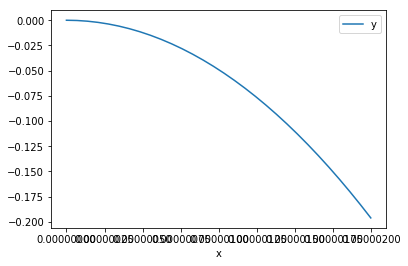

In [14]:
tragDF.plot(x='x', y='y')

In [15]:
# plot moth at certain timesteps
# plot final positions
def plotMoth(x,y,theta, phi, F, alpha, tau0, fig, ax):
    # plot moth and force

    thoraxLen = 0.908 * 2# cm
    abLen = 1.747 *2 #cm
    bodyWidth = 1.1


    # plot trajectory
    #fig, ax = plt.subplots( figsize = [10,10])
    ax.set_aspect('equal', 'datalim')
    #ax.plot(x,y, label = 'trajectory x vs y')

    center = np.array([x, y])
    head = center + np.array(pol2cart(thoraxLen, theta))
    abTip = center + np.array(pol2cart(abLen, phi))



    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.9, angle = math.degrees(theta))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.9, angle = math.degrees(phi))
    
#     torqueArc = Arc([x,y], 1, 1, angle=0.0, theta1= np.degrees(theta), theta2=np.degrees(phi), color = "#B61212")
    
    
    ax.add_artist(el)
    ax.add_artist(el2)
#     ax.add_artist(torqueArc)
    
#     # add torque arrow
#     ax.arrow(x = x + 1, y = forceCenter[1], 
#              dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
#             head_width = 0.2, color = "#B61212")



    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)

    # plot force 
    forceAlpha = alpha
    forceCenter = midpoint(center, head)
    forceMagnitude = F / 15000 # scale 
    forceAngle = theta + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")


In [16]:
# make tmp dir for images
tmpDir2 = os.path.join(r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs', "MothVid_Velocity")
if not os.path.exists(tmpDir2):
    os.mkdir(tmpDir2)

In [17]:
tau0

20

In [18]:
# plt.figure(figsize = [10,10])
# plt.axes().set_aspect('equal', 'datalim')
sns.set_style("whitegrid", {'axes.grid' : True})

maxFrms = len(x)

xlim = [np.min(x[0:maxFrms+1])-5, np.max(x[0:maxFrms+1])+5]
ylim =[np.min(y[0:maxFrms+1])-5, np.max(y[0:maxFrms+1])+5]
xrng = np.diff(xlim)
yrng = np.diff(ylim)
maxrng = np.max([xrng, yrng])
newxlim = [np.sum(xlim)/2 - maxrng /2, np.sum(xlim)/2 + maxrng /2]
newylim = [np.sum(ylim)/2 - maxrng /2, np.sum(ylim)/2 + maxrng /2 ]


for ii in np.arange(1, maxFrms, 1):
    fig, ax = plt.subplots( figsize = [10,10])

    plt.plot(x[0:ii+1], y[0:ii+1], c= 'orange', label = "Python")
    plotMoth(x[ii], y[ii],theta[ii], phi[ii], F, alpha, tau0, fig, ax)
    

    ax.set_ylim(newylim)
    ax.set_xlim(newxlim)
    ax.set_ylabel("vertical position (cm)")
    ax.set_xlabel("horizontal position (cm)")
    
#     # add torque
#     if tau0 < 0:
#         marker = r'$\circlearrowleft$'
#     else:
#         marker = r'$\circlearrowright$'
#     ax.plot(x[ii],y[ii], marker=marker,ms=tau0/100000,  color = "#B61212")
    fig.savefig(os.path.join(tmpDir2, str(ii).zfill(4)+ ".png"), dpi = 200, bbox_inches='tight')
    # plt.legend()
    plt.close()
    if np.mod(ii, 10) == 0:
        print(ii)
#     plt.show()

10
20


In [19]:
# make into video
os.chdir(tmpDir2)

os.system('ffmpeg -start_number 0 -r 30 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264   -b:v 10000k -pix_fmt yuv420p -y 0000001_output_mothPath2.mp4')

0

In [33]:
# import model and scaler
modelPath = r"D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels\Opt_rmsprop__Dro_0__Num_512_512_512_16__Wei_0_2019_06_13__02_19_18veloc.h5"
model = load_model(modelPath)

# read in scalers
scalerX = pickle.load(open("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput\scalerX_veloc.pkl", "rb"))
scalerY = pickle.load(open("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput\scalerY_veloc.pkl", "rb"))


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               7680      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 541,251
Trainable params: 541,251
Non-trainable params: 0
_________________________________________________________________


In [22]:
# # REFREF: check model loss

# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")


In [23]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [24]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [30]:
# make dataset
X = trainDF.loc[:, ["phi_0", "theta_0", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0",
                   "x_99", "y_99", "phi_99",  "theta_99",
                   "x_dot_99", "y_dot_99","phi_dot_99","theta_dot_99"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau"] ]

In [31]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [34]:
# scale data 

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [35]:
Xtest_scaled.shape

(1980102, 14)

In [36]:
model.evaluate(Xtest_scaled, Ytest_scaled)

1980102/1980102 [==============================] - 76s 38us/step


[0.0012489242974622523, 0.0012489242974622523]

In [37]:
# calculate F and alpha from Fx and Fy

# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)


def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)

def F_alpha_calc (Fx, Fy):
    q = quadrant(Fx, Fy)
    alpha = angleCalc(Fx, Fy, q)
    F = np.sqrt(Fx**2 + Fy**2)
    return(F, alpha)


In [47]:
#inputData = # make dataset
Xcols = ["phi_0", "theta_0", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0",
                   "x_99", "y_99", "phi_99",  "theta_99",
                   "x_dot_99", "y_dot_99","phi_dot_99","theta_dot_99"]



In [41]:
# refref calculate new x and y from error

___

# Start loop

In [48]:
sns.set_style("whitegrid", {'axes.grid' : True})

overallCtr = 1


# refref: maybe the derivatives should be in the input, so it doesn't go too fast

# define initial position and goal position


# x,xd,y,yd,theta,thetad,phi,phid
where_I_am = OrderedDict({
                        "x_0": [0], 
                        "x_dot_0":[-0.0001], 
                        "y_0":[0], 
                        "y_dot_0": [0.0001]  ,
                        "theta_0": [np.pi/2]  ,
                        "theta_dot_0": [0.0001]  , 
                        "phi_0": [3*np.pi/2]   ,
                        "phi_dot_0":[0.0001] })


where_I_want2b = OrderedDict({"x_99": [0],
                              "y_99": [0],
                              "phi_99": [3*np.pi/2],
                              "theta_99": [np.pi/2], 
                             "x_dot_99": [0.00001], 
                             "y_dot_99": [0.00001], 
                             "x_dot_99": [0.00001], 
                              "theta_dot_99": [0.00001], 
                             "phi_dot_99": [0.00001]})

xList = []
yList = []

prevXY = [where_I_am["x_0"][0], where_I_am["y_0"][0]]

goalXY = [where_I_want2b["x_99"][0], where_I_want2b["y_99"][0]]

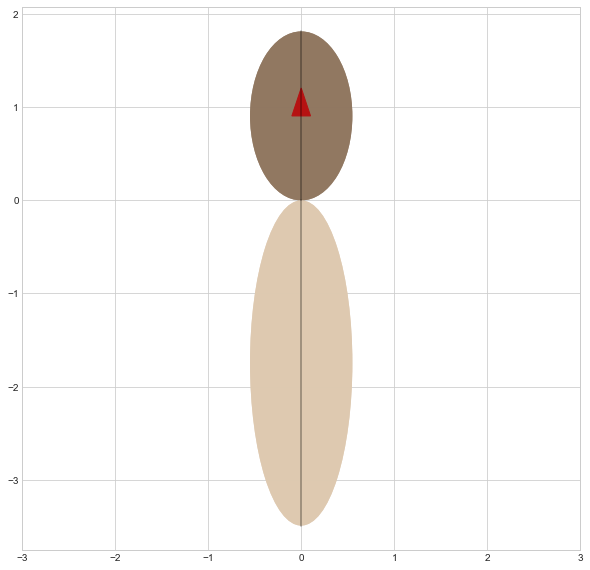

In [49]:
fig, ax = plt.subplots(figsize = [10,10])

# don't pay attention to F, alpha, tau0
plotMoth(where_I_am["x_0"][0],where_I_am["y_0"][0],where_I_am["theta_0"][0], where_I_am["phi_0"][0], F, alpha, tau0, fig, ax)
plotMoth(where_I_want2b["x_99"][0],
         where_I_want2b["y_99"][0],
         where_I_want2b["theta_99"][0],
         where_I_want2b["phi_99"][0], F, alpha, tau0, fig, ax)

In [50]:
inputData =  pd.DataFrame(OrderedDict(list(where_I_am.items()) + list(where_I_want2b.items())))
inputData = inputData.loc[:, Xcols]
#print(inputData)



In [51]:
# predict force needed to attain 
## scale data and transform
X_scaled = scalerX.transform(inputData)


## predict with nnet
pred = model.predict(X_scaled[0, :].reshape(1, -1))

# inverse transform
pred_trans = scalerY.inverse_transform(pred)

pred_trans[0]

array([ 4385.01074219,   950.91711426,  5715.46044922], dtype=float32)

In [52]:
tmpDir2

'D:\\Dropbox\\AcademiaDropbox\\mothMachineLearning_dataAndFigs\\Figs\\MothVid_Velocity'

In [55]:
###### start of loop
##### hybrid approach

for jj in range(20):

    inputData =  pd.DataFrame(OrderedDict(list(where_I_am.items()) + list(where_I_want2b.items())))
    inputData = inputData.loc[:, Xcols]


    # predict force needed to attain 
    ## scale data and transform
    X_scaled = scalerX.transform(inputData)
    
    
    ## predict with nnet
    pred = model.predict(X_scaled[0, :].reshape(1, -1))

    # inverse transform
    pred_trans = scalerY.inverse_transform(pred)
    Fx, Fy, tau0  = pred_trans[0]

    # convert FX, Fy, back to F, alpha
    # F, alpha = cart2pol(Fx, Fy)
    F, alpha = F_alpha_calc(Fx, Fy)


    # plug predictions into simulation
    FAlphaTau_list = [F, alpha, tau0]

    # x,xd,y,yd,theta,thetad,phi,phid
    state0_ICs = [ v[0] for v in where_I_am.values() ]

    x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_OneRun(t, state0_ICs, FAlphaTau_list, globalList)

    # add previous position to x and y
    x = x + prevXY[0]
    y = y + prevXY[1]
    
    # plot actual position
    xList.extend(x.tolist())
    yList.extend(y.tolist())



    maxFrms = len(x)



    # refref: add x's to each plot
    for ii in np.arange(0, maxFrms, 1):
        fig, ax = plt.subplots(figsize = [10,10])

        plt.plot(xList[:-(maxFrms-ii)], yList[:-(maxFrms-ii)], c= 'orange', label = "moth trajectory", alpha = 0.3)
        #plt.plot(where_I_want2b["x_99"], where_I_want2b["y_99"], c= 'blue', label = "Goal", marker = "o", linewidth = 0)
        plt.plot(goalXY[0], goalXY[1], c= 'blue', label = "Goal", marker = "o", linewidth = 0)
        plotMoth(x[ii], y[ii],theta[ii], phi[ii], F, alpha, tau0, fig, ax)


#         ax.set_ylim([-30, 30])
#         ax.set_xlim([-30, 30])
        ax.set_ylim([-80, 80])
        ax.set_xlim([-80, 80])
        ax.set_ylabel("vertical position (cm)")
        ax.set_xlabel("horizontal position (cm)")
        plt.legend()
        fig.savefig(os.path.join(tmpDir2, str(overallCtr).zfill(4)+ ".png"), dpi = 200, bbox_inches='tight')
        #plt.show()
        overallCtr += 1


        plt.close()
        if np.mod(ii, 3) == 0:
            print(ii)



    # calculate error and compute new initial position, but keep goal position the same

    ### REFREF: may be calculating this incorrectly
    ### where I am should always start at x_0, y_0 == (0, 0)
    ### where I want to be should be the error....
    
    # update prevXY
    prevXY = [x[-1], y[-1]]
    
    # x,xd,y,yd,theta,thetad,phi,phid
    where_I_am2 = OrderedDict({
                            "x_0": [0], 
                            "x_dot_0":[xd[-1]], 
                            "y_0":[0], 
                            "y_dot_0": [yd[-1]]  ,
                            "theta_0": [theta[-1]]  ,
                            "theta_dot_0": [thetad[-1]] , 
                            "phi_0": [phi[-1]]   ,
                            "phi_dot_0":[phid[-1]] })


    # calculate true position
    actual_whereIam = OrderedDict({
                            "x": [where_I_want2b["x_99"] + x],
                            "y":[where_I_want2b["x_99"] + y]})
    
    # refref: i'm not sure this is right
    
    where_I_want2b2 = OrderedDict({"x_99": [ goalXY[0] - prevXY[0] ],
                              "y_99": [goalXY[1] - prevXY[1]],
                              "phi_99": [3*np.pi/2],
                              "theta_99": [np.pi/2], 
                                  "x_dot_99": [0.00001], 
                             "y_dot_99": [0.00001], 
                             "x_dot_99": [0.00001], 
                              "theta_dot_99": [0.00001], 
                             "phi_dot_99": [0.00001]})
    
    # update whereIam
    where_I_am = where_I_am2
    where_I_want2b = where_I_want2b2
    
    

    print("loop", jj)

0
3
6
9
12
15
18
21
24
27
loop 0
0
3
6
9
12
15
18
21
24
27
loop 1
0
3
6
9
12
15
18
21
24
27
loop 2
0
3
6
9
12
15
18
21
24
27
loop 3
0
3
6
9
12
15
18
21
24
27
loop 4
0
3
6
9
12
15
18
21
24
27
loop 5
0
3
6
9
12
15
18
21
24
27
loop 6
0
3
6
9
12
15
18
21
24
27
loop 7
0
3
6
9
12
15
18
21
24
27
loop 8
0
3
6
9
12
15
18
21
24
27
loop 9
0
3
6
9
12
15
18
21
24
27
loop 10
0
3
6
9
12
15
18
21
24
27
loop 11
0
3
6
9
12
15
18
21
24
27
loop 12
0
3
6
9
12
15
18
21
24
27
loop 13
0
3
6
9
12
15
18
21
24
27
loop 14
0
3
6
9
12
15
18
21
24
27
loop 15
0
3
6
9
12
15
18
21
24
27
loop 16
0
3
6
9
12
15
18
21
24
27
loop 17
0
3
6
9
12
15
18
21
24
27
loop 18
0
3
6
9
12
15
18
21
24
27
loop 19


In [56]:
# make video
# make into video|
os.chdir(tmpDir2)

os.system('ffmpeg -start_number 1 -r 60 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264   -b:v 10000k -pix_fmt yuv420p -y 0000000_output_mothPath.mp4')

0

In [ ]:
where_I_am

In [ ]:
prevXY

In [ ]:
goalXY

In [ ]:
where_I_want2b

In [ ]:
# refref: do the same thing with a smaller, pruned network

___

# Make vid of multiple moth trajectoies



___

In [ ]:
globalDict = OrderedDict({"bhead": 0.507,
            "ahead": 0.908,
            "bbutt": 0.1295,
            "abutt": 1.7475, 
            "rho": 1, 
            "rhoA": 0.00118, 
            "muA": 0.000186, 
            "L1": 0.908, 
            "L2": 1.7475,  
            "L3": 0.75,
            "K": 29.3,
            "c":  14075.8,
            "g": 980.0,
            "betaR":  0.0,
            "nstep": 40,
            "nrun" : 1  # (max) number of  trajectories.
            })
# Calculated variables
globalDict['m1'] = globalDict['rho']*(4/3)*np.pi*(globalDict['bhead']**2)*globalDict['ahead']
globalDict["m2"] = globalDict["rho"]*(4/3)*np.pi*(globalDict["bbutt"]**2)*globalDict["abutt"]
globalDict["echead"] = globalDict["ahead"]/globalDict["bhead"]
globalDict['ecbutt'] = globalDict['abutt']/globalDict['bbutt']
globalDict['I1'] = (1/5)*globalDict['m1']*(globalDict['bhead']**2)*(1 + globalDict['echead']**2)
globalDict['I2'] = (1/5)*globalDict['m2']*(globalDict['bbutt']**2)*(1 + globalDict['ecbutt']**2)
globalDict['S_head'] = np.pi*globalDict['bhead']**2
globalDict['S_butt'] = np.pi*globalDict['bbutt'] **2
t = np.linspace(0, 0.1, num = globalDict["nstep"], endpoint = True)

# convert dict to list, since @jit works better with lists
globalList = [ v for v in globalDict.values() ]

In [ ]:
# plug predictions into simulation
FAlphaTau_list = [F, alpha, tau0]




# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = [0.0, 0.0001, 0.0, 0.0001, np.pi, 0.0001, 0.0, 0.0001]




x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_OneRun(t, state0_ICs, FAlphaTau_list, globalList)

In [ ]:
F, alpha, tau0 = (np.random.rand(3)* 1000).tolist()
FAlphaTau_list = [F, alpha, tau0]


state0_ICs = [0.0, 0.0001, 0.0, 0.0001, np.pi/2 - 0.3,0.0001, -np.pi/2 - 0.3,0.0001]
state0_ICs


In [ ]:
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_OneRun(t, state0_ICs, FAlphaTau_list, globalList)

In [ ]:
plt.plot(x, y)

In [ ]:
len(x)

In [ ]:
tmpDir3 = os.path.join(r'D:\Dropbox\AcademiaDropbox\CallinStuff\Presentations\eScience_Community_Seminar_2019', "MPC_Example")
if not os.path.exists(tmpDir3):
    os.mkdir(tmpDir3)

overallCtr2 = 1


xlist = []
ylist = []

In [ ]:
for pathNum in range(20):
    F, alpha, tau0 = (np.random.rand(3)* 10000).tolist()
    tau0 = tau0*10
    FAlphaTau_list = [F, alpha, tau0]
    x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_OneRun(t, state0_ICs, FAlphaTau_list, globalList)

    xlist.extend(x)
    ylist.extend(y)


    for ii in np.arange(0, globalDict["nstep"], 1):
        fig, ax = plt.subplots(figsize = [10,10])

        plt.scatter(xlist[:-(globalDict["nstep"]-ii-1)], ylist[:-(globalDict["nstep"]-ii-1)], c= 'orange', label = "moth trajectory", s = 2)
        plotMoth(x[ii], y[ii],theta[ii], phi[ii], F, alpha, tau0, fig, ax)


        ax.set_ylim([-30, 30])
        ax.set_xlim([-30, 30])
        ax.set_ylabel("vertical position (cm)")
        ax.set_xlabel("horizontal position (cm)")
        plt.legend()
        fig.savefig(os.path.join(tmpDir3, str(overallCtr2).zfill(4)+ ".png"), dpi = 200, bbox_inches='tight')
        overallCtr2 += 1


        plt.close()

In [ ]:
# make video
# make into video|
os.chdir(tmpDir3)

os.system('ffmpeg -start_number 1 -r 30 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2, setpts=0.2*PTS" -c:v libx264   -b:v 10000k -pix_fmt yuv420p -y 0000000_MPCVID.mp4')

In [ ]:
ii = 0
xlist[:-(globalDict["nstep"]-ii-1)]

# Make training and test set

In [ ]:
# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

In [ ]:
# refref: check for repeats!

In [ ]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

In [ ]:
print(trainDF.shape)
trainDF.head()

In [ ]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [ ]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [ ]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [ ]:
X.head()

In [ ]:
Y.head()

In [ ]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [ ]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [ ]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

In [ ]:
# save scalers, to be used on test set
scalerfileX = 'scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

#model.get_config()
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=150, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [ ]:
K.clear_session()

In [ ]:
# refref: start with small network and then build up
# refref: start with large network and prune

In [ ]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [32, 32, 32, 32], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [ ]:
# load pre-trained model

# model = load_model(r"D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels\Opt_rmsprop__Dro_0.0__Num_400_400_400_16__Wei_0.0.h5")


In [ ]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }



model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).replace("[", "").replace("]", "").replace(", ", "_")[0:-2]+ "_" + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_")
print(modelName)

model.summary()

In [ ]:
# show random weight matrices
# show images for matrices

wts = model.get_weights().copy()

plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.7, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('PRGn', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2-5:256//2+5, :] = white
newcmp = ListedColormap(newcolors)


for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 413])
        axs[jj].get_xaxis().set_ticks([0, 200, 400])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        

    
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
            
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 413])
        axs[jj].axes.set_xlim([-1, 413])
        #axs[jj].axis('off')
        
        
    if ii == 9:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_xaxis().set_ticks([0])
        axs[jj].axes.set_xlim([-1, 413])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        #axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_yaxis().set_ticks([])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.set_ylim([-1, 32])

    
    #axs[jj].axis('off')

cbaxes = inset_axes(axs[8], width="5%", height="75%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    
    
#fig.colorbar(im, orientation="horizontal", pad=0.2)



plt.savefig(os.path.join(figDir, "RandomWeightMatrices" + modelName + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# train

In [ ]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [ ]:
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=15, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [ ]:
# # fit model without regularization
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 1000, verbose = 2, 
                        batch_size=2**14, callbacks = [earlystop], validation_split = 0.3)
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

In [ ]:
historyDict["mean_squared_error"].extend(history.history["mean_squared_error"][0:])
historyDict["val_mean_squared_error"].extend(history.history["val_mean_squared_error"][0:])

In [ ]:
# refref: save history

In [ ]:
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history_dictionary['val_mean_squared_error'])+1),
                   len(model_history_dictionary['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        plt.ylim([0.0001, 0.05])
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_NOTpruned_2.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))
    plt.show()



wts = model.get_weights().copy()



# print sizes of each weight matrix
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

print(np.sum(wtLengths), "total weights")

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")
    
plot_model_history_fromDict(historyDict, saveFig = True)

In [ ]:

wts = model.get_weights().copy()

# if I need to remake, use this
# wtsPath = "D:\Dropbox\AcademiaDropbox\CallinStuff\Presentations\eScience_Community_Seminar_2019\Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2019_05_30__11_59_54_wts.pkl"
# wts =  pickle.load(open(wtsPath, 'rb'))

plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.7, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('PRGn', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2:256//2 + 1, :] = white
newcmp = ListedColormap(newcolors)


for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 413])
        axs[jj].get_xaxis().set_ticks([0, 200, 400])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        

    
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
            
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 413])
        axs[jj].axes.set_xlim([-1, 413])
        #axs[jj].axis('off')
        
        
    if ii == 9:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_xaxis().set_ticks([0])
        axs[jj].axes.set_xlim([-1, 413])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        #axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_yaxis().set_ticks([])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.set_ylim([-1, 32])

    
    #axs[jj].axis('off')

cbaxes = inset_axes(axs[8], width="5%", height="75%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    
    
#fig.colorbar(im, orientation="horizontal", pad=0.2)



plt.savefig(os.path.join(figDir, "TrainedWeightMatrices" + modelName + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)

# refref: plot predictions on test set and make figures.



In [ ]:
# predict on test set
# apply same transformation to test data
# Xtest_scaled = scalerX.transform(Xtest)
# Ytest_scaled = scalerY.transform(Ytest)


Ytest_pred = model.predict(Xtest_scaled)

In [ ]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = X.columns)
YtestDF = pd.DataFrame(scalerY.inverse_transform(Ytest_scaled), columns = Y.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Y.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

In [ ]:
#df_c = df_c[0:100000]

In [ ]:
# make plots
from sklearn.metrics import r2_score

plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array([30, 10]) / 1.3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.7)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

ylabs = [r"g*cm/$s^2$", r"g*cm/$s^2$", r"g*$cm^2$/$s^2$", "cm/s", "cm/s", "rad/s", "rad/s"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(df_c.shape[1] //2):
    try:
        axs[ii].hexbin(y = df_c.iloc[:,ii],x = df_c.iloc[:,ii + 7], gridsize = 50, cmap = cmap)
        #axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
        else:
            axs[ii].set_ylabel(ylabs[ii])
        axs[ii].set_title(df_c.columns[ii])
        axs[ii].plot(df_c.iloc[:,ii], df_c.iloc[:,ii], 'grey', linewidth = 1, linestyle  = "--")
        
        # annotate with R^2
        axs[ii].text(np.max(df_c.iloc[:,ii])*0.1, np.min(df_c.iloc[:,ii])*0.9, r'$r^2$ =' + str(np.round((r2_score(df_c.iloc[:,ii ],  df_c.iloc[:,ii+7])), 3)))
        axs[ii].set_xlim([-np.max(np.abs(df_c.iloc[:,ii+7])), np.max(np.abs(df_c.iloc[:,ii+7]))])
    except:
        pass

# # residual plots x = predicted, y = actual - predicted
for jj in range(df_c.shape[1] //2):
    
    ii = jj + 7
    try:
        axs[ii].hexbin(x = df_c.iloc[:,jj],
                     y = df_c.iloc[:,jj ] - df_c.iloc[:,jj+7], gridsize = (35, 50), cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")

        if(jj == 0):
            axs[ii].set_ylabel("Actual - Predicted\n" + ylabs[jj])
        else:
            axs[ii].set_ylabel(ylabs[jj])
        
        axs[ii].hlines(y = 0, xmin = np.min( df_c.iloc[:,jj+7]), 
                       xmax = np.max( df_c.iloc[:,jj+7]), linestyle =  "--", linewidth = 1)
        axs[ii].set_ylim([-np.max(np.abs(df_c.iloc[:,jj ] - df_c.iloc[:,jj+7])), np.max(np.abs(df_c.iloc[:,jj ] - df_c.iloc[:,jj+7]))])
        
    except:
        pass


fig.savefig(os.path.join(figDir, "PredVActual_" + modelName + ".png"), dpi = 500, bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:

#(y_true, y_pred, sample_weight=None, multioutput=’uniform_average’)

In [ ]:
#  save model
model.save(os.path.join(figDir,  modelName + '_notPruned.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(figDir, wtsFile), 'wb'))

# save history
histName = modelName + '_history.pkl'
pickle.dump(historyDict, open(os.path.join(figDir, histName), 'wb'))

In [ ]:
for jj in range(7):
    print (r2_score(df_c.iloc[:,jj ],  df_c.iloc[:,jj+7]))

___

## START NEW ITEM: train and trim weights

In [ ]:
# train and trim weights

In [ ]:


model.summary()

In [ ]:
# read in data
#wts =  pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# print sizes of each weight matrix
wtLengths = []
for ii in range(len(wts)):
    print(wts[ii].shape)
    wtLengths.append(np.prod(wts[ii].shape))

print(np.sum(wtLengths), "total weights")

In [ ]:
# # start training
# historyDict = {"mean_squared_error": [], 
#                "val_mean_squared_error": []}

In [ ]:
# start pruning
modelName + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_") + '_Pruned.h5'

In [ ]:
numCuts = 1

In [ ]:
# refref: 
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)


# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**14, epochs = 1, 
                            callbacks = [earlystop])
        
        # refref: earlystop doesn't do anything here
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent[numCuts], 50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                model.save(os.path.join(figDir,  modelName + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_") + '_Pruned.h5'))
                break
                       
                    
    ## refref: may want to save weights before each pruning, so I can go back, if I need to
    ## refref: should I be pruning the biases too?
    
    ## keep running tally of min mse, and if we can't get back to the min, then break
#     print("Min MSE for this prune ", np.min(MSE_tmp), "______overall Min MSE ", np.min(historyDict["mean_squared_error"]))
#     if np.min(MSE_tmp) > np.min(historyDict["mean_squared_error"]):
#         print("no more gain by pruning:  STOPPING Pruning")
#         break
    
    numCuts += 1
    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)

In [ ]:
print(numCuts)
(50 - cutPercent[numCuts]) * 2 # percent of original network size that is used the pruned version

In [ ]:
#  save model
model.save(os.path.join(figDir,  modelName + '_Pruned.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts_pruned.pkl'
pickle.dump(wts, open(os.path.join(figDir, wtsFile), 'wb'))

# save history
histName = modelName + '_history_pruned.pkl'
pickle.dump(historyDict, open(os.path.join(figDir, histName), 'wb'))

In [ ]:
# numCuts = 0

In [ ]:
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history_dictionary['val_mean_squared_error'])+1),
                   len(model_history_dictionary['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        plt.ylim([0.0001, 0.05])
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
    plt.show()



wts = model.get_weights().copy()



# print sizes of each weight matrix
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

print(np.sum(wtLengths), "total weights")

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")
    
plot_model_history_fromDict(historyDict, saveFig = True)

In [ ]:
str(dictLen).zfill(4)

In [ ]:
# make video of training
tmpDir = os.path.join(figDir, "tmpImgs")
if not os.path.exists(tmpDir):
    os.mkdir(tmpDir)
fig, axs = plt.subplots(1,1,figsize=(10,5))
#for dictLen in np.arange(1, len(historyDict["mean_squared_error"])):
for dictLen in range(300):

    # save images
    
    # summarize history for accuracy
    axs.plot(range(1,len(historyDict['mean_squared_error'][dictLen-1:dictLen])+1),
             historyDict['mean_squared_error'][dictLen-1:dictLen])
    axs.plot(range(1,len(historyDict['val_mean_squared_error'][dictLen-1:dictLen])+1),
             historyDict['val_mean_squared_error'][dictLen-1:dictLen])
    axs.set_title('Model MSE = '+ str(format_e(historyDict['val_mean_squared_error'][dictLen])))
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
#     axs.set_xticks(np.arange(1,len(historyDict['val_mean_squared_error'][dictLen-1:dictLen])+1),
#                    len(historyDict['val_mean_squared_error'][dictLen-1:dictLen])//10)
    axs.legend(['train', 'val'], loc='lower left')
    plt.yscale('log') #logarithmic scale for y axis

    plt.ylim([0.0001, 0.05])
    fig.savefig(os.path.join(tmpDir, str(dictLen).zfill(4)+ ".png"), dpi = 120,  pad_inches = 0.5)
    #plt.close()
    
    if np.mod(dictLen, 100) == 0:
        print(dictLen)






In [ ]:
# make video of training
tmpDir = os.path.join(figDir, "tmpImgs")
if not os.path.exists(tmpDir):
    os.mkdir(tmpDir)
fig, axs = plt.subplots(1,1,figsize=(10,5))
for dictLen in np.arange(1, len(historyDict["mean_squared_error"])):
#for dictLen in np.arange(1, 100):

    # save images
    
    # summarize history for accuracy
    axs.plot([dictLen -1, dictLen],
             historyDict['mean_squared_error'][dictLen-1:dictLen+1], c= "C0")
    axs.plot([dictLen -1, dictLen],
             historyDict['val_mean_squared_error'][dictLen-1:dictLen+1], c= "C1")
    axs.set_title('Model MSE = '+ str(format_e(historyDict['val_mean_squared_error'][dictLen])))
    axs.set_ylabel('mean squared error')
    axs.set_xlabel('Epoch')
#     axs.set_xticks(np.arange(1,len(historyDict['val_mean_squared_error'][dictLen-1:dictLen])+1),
#                    len(historyDict['val_mean_squared_error'][dictLen-1:dictLen])//10)
    axs.legend(['train', 'val'], loc='lower left')
    plt.yscale('log') #logarithmic scale for y axis

    plt.ylim([0.0001, 0.05])
    fig.savefig(os.path.join(tmpDir, str(dictLen).zfill(4)+ ".png"), dpi = 120,  pad_inches = 0.5)
    #plt.close()
    #plt.show()
    
    if np.mod(dictLen, 100) == 0:
        print(dictLen)






In [ ]:
# make into video
os.chdir(tmpDir)

os.system('ffmpeg -start_number 0   -r 50 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -b:v 10000k  -pix_fmt yuv420p -y  0000000_output_epochs.mp4')

In [ ]:
Ytest_pred = model.predict(Xtest_scaled)

In [ ]:
# make data frames
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = X.columns)
YtestDF = pd.DataFrame(scalerY.inverse_transform(Ytest_scaled), columns = Y.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Y.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

In [ ]:
len(historyDict["mean_squared_error"])

In [ ]:
df_c = df_c.iloc[0:10000,:]

In [ ]:
# make plots
from sklearn.metrics import r2_score

plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array([30, 10]) / 1.3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.7)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

ylabs = [r"g*cm/$s^2$", r"g*cm/$s^2$", r"g*$cm^2$/$s^2$", "cm/s", "cm/s", "rad/s", "rad/s"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(df_c.shape[1] //2):
    try:
        axs[ii].hexbin(y = df_c.iloc[:,ii],x = df_c.iloc[:,ii + 7], gridsize = 50, cmap = cmap)
        #axs[ii].set_xlabel("Predicted Value\n(unscaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
        else:
            axs[ii].set_ylabel(ylabs[ii])
        axs[ii].set_title(df_c.columns[ii])
        axs[ii].plot(df_c.iloc[:,ii], df_c.iloc[:,ii], 'grey', linewidth = 1, linestyle  = "--")
        
        # annotate with R^2
        axs[ii].text(np.max(df_c.iloc[:,ii])*0.1, np.min(df_c.iloc[:,ii])*0.9, r'$r^2$ =' + str(np.round((r2_score(df_c.iloc[:,ii ],  df_c.iloc[:,ii+7])), 3)))
        axs[ii].set_xlim([-np.max(np.abs(df_c.iloc[:,ii+7])), np.max(np.abs(df_c.iloc[:,ii+7]))])
    except:
        pass

# # residual plots x = predicted, y = actual - predicted
for jj in range(df_c.shape[1] //2):
    
    ii = jj + 7
    try:
        axs[ii].hexbin(x = df_c.iloc[:,jj],
                     y = df_c.iloc[:,jj ] - df_c.iloc[:,jj+7], gridsize = (35, 50), cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")

        if(jj == 0):
            axs[ii].set_ylabel("Actual - Predicted\n" + ylabs[jj])
        else:
            axs[ii].set_ylabel(ylabs[jj])
        
        axs[ii].hlines(y = 0, xmin = np.min( df_c.iloc[:,jj+7]), 
                       xmax = np.max( df_c.iloc[:,jj+7]), linestyle =  "--", linewidth = 1)
        axs[ii].set_ylim([-np.max(np.abs(df_c.iloc[:,jj ] - df_c.iloc[:,jj+7])), np.max(np.abs(df_c.iloc[:,jj ] - df_c.iloc[:,jj+7]))])
        
    except:
        pass


fig.savefig(os.path.join(figDir, "PredVActual_" + str(len(historyDict["mean_squared_error"])) +  modelName + ".png"), dpi = 500, bbox_inches='tight')
plt.show()

In [ ]:
wts = model.get_weights().copy()

plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.7, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('PRGn', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2:256//2+1, :] = white
newcmp = ListedColormap(newcolors)

for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.7, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('PRGn', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2, :] = white
newcmp = ListedColormap(newcolors)


for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 413])
        axs[jj].get_xaxis().set_ticks([0, 200, 400])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        

    
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
            
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 413])
        axs[jj].axes.set_xlim([-1, 413])
        #axs[jj].axis('off')
        
        
    if ii == 9:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_xaxis().set_ticks([0])
        axs[jj].axes.set_xlim([-1, 413])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        #axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_yaxis().set_ticks([])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.set_ylim([-1, 32])

    
    #axs[jj].axis('off')

cbaxes = inset_axes(axs[8], width="5%", height="75%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    
    
#fig.colorbar(im, orientation="horizontal", pad=0.2)



plt.savefig(os.path.join(figDir, "Pruned_WeightMatrices" + str(len(historyDict["mean_squared_error"]))  + modelName + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)

___

## Show example small network

In [ ]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [20, 20, 16],
               "weightRegularization": 0
              }



model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).replace("[", "").replace("]", "").replace(", ", "_")[0:-2]+ "_" + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_")
print(modelName)

model.summary()

In [ ]:
wts = model.get_weights().copy()

plt.close("all")
fig, axs = plt.subplots(2,4, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.4, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('PRGn', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2:256//2 + 1, :] = white
newcmp = ListedColormap(newcolors)


for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))

    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 21])
        axs[jj].get_xaxis().set_ticks([0, 10])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])   
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")
        axs[jj].axes.set_ylim([-1, 21])
        axs[jj].axes.set_xlim([-1, 21])
              
    if ii == 7:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
        axs[jj].get_xaxis().set_ticks([0])
        axs[jj].axes.set_xlim([-1, 21])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


cbaxes = inset_axes(axs[6], width="5%", height="75%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    

plt.savefig(os.path.join(figDir, "RondomWTS_small" + modelName + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# # fit model without regularization
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 10, verbose = 2, 
                        batch_size=2**14, callbacks = [earlystop], validation_split = 0.3)
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

In [ ]:
ctr = 0

In [ ]:

for ii in range(100):
    
        # # fit model without regularization
    stt = time.time()
    history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 10, verbose = 2, 
                            batch_size=2**14, callbacks = [earlystop], validation_split = 0.3)
    winsound.PlaySound("*", winsound.SND_ALIAS)
    endd = time.time() - stt
    print(endd)





    wts = model.get_weights().copy()

    # if I need to remake, use this
    # wtsPath = "D:\Dropbox\AcademiaDropbox\CallinStuff\Presentations\eScience_Community_Seminar_2019\Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2019_05_30__11_59_54_wts.pkl"
    # wts =  pickle.load(open(wtsPath, 'rb'))

    plt.close("all")
    fig, axs = plt.subplots(2,4, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
    fig.subplots_adjust(hspace = -0.4, wspace=0.1, bottom = -0.1 )
    axs = axs.ravel("F")


    PRGn = cm.get_cmap('PRGn', 256)
    newcolors = PRGn(np.linspace(0, 1, 256))
    white = np.array([0.8, 0.8, 0.8, 1])
    newcolors[256//2:256//2 + 1, :] = white
    newcmp = ListedColormap(newcolors)



    for jj, ii in enumerate(np.arange(0, len(wts), 1)):




        if len(wts[ii].shape) < 2: 
            wtsTmp = wts[ii].reshape(1,-1).copy()
        else:
            wtsTmp = wts[ii].copy()

        im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                                  vmin=-3.0, vmax=3.0))





        if np.mod(ii+1, 2) == 0:
            axs[jj].axes.get_yaxis().set_visible(False)
            axs[jj].axes.set_ylim([-1, 1])
            axs[jj].axes.set_xlim([-1, 21])
            axs[jj].get_xaxis().set_ticks([0, 10])

            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)



        if (np.mod(jj, 2) == 0) and (jj != 0):
            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].get_xaxis().set_ticks([])
            axs[jj].get_yaxis().set_ticks([])

            axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


            #axs[jj].axes.get_yaxis().set_visible(False)
            axs[jj].axes.set_ylim([-1, 21])
            axs[jj].axes.set_xlim([-1, 21])
            #axs[jj].axis('off')


        if ii == 7:
            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].get_xaxis().set_ticks([])
            axs[jj].get_yaxis().set_ticks([])


            #axs[jj].axes.get_yaxis().set_visible(False)
            axs[jj].get_xaxis().set_ticks([0])
            axs[jj].axes.set_xlim([-1, 21])

        if ii == 0:
            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].get_xaxis().set_ticks([])

            axs[jj].get_yaxis().set_ticks([])
            axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")

    cbaxes = inset_axes(axs[6], width="5%", height="75%", loc= "center") 
    cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    

    ctr += 1

    plt.savefig(os.path.join(figDir, "TrainedWts_small_"+ str(ctr) + modelName  + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
def saveWeightImages(model):
    
     wts = model.get_weights().copy()

    # if I need to remake, use this
    # wtsPath = "D:\Dropbox\AcademiaDropbox\CallinStuff\Presentations\eScience_Community_Seminar_2019\Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2019_05_30__11_59_54_wts.pkl"
    # wts =  pickle.load(open(wtsPath, 'rb'))

    plt.close("all")
    fig, axs = plt.subplots(2,4, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
    fig.subplots_adjust(hspace = -0.4, wspace=0.1, bottom = -0.1 )
    axs = axs.ravel("F")


    PRGn = cm.get_cmap('PRGn', 256)
    newcolors = PRGn(np.linspace(0, 1, 256))
    white = np.array([0.8, 0.8, 0.8, 1])
    newcolors[256//2:256//2 + 1, :] = white
    newcmp = ListedColormap(newcolors)



    for jj, ii in enumerate(np.arange(0, len(wts), 1)):




        if len(wts[ii].shape) < 2: 
            wtsTmp = wts[ii].reshape(1,-1).copy()
        else:
            wtsTmp = wts[ii].copy()

        im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                                  vmin=-3.0, vmax=3.0))





        if np.mod(ii+1, 2) == 0:
            axs[jj].axes.get_yaxis().set_visible(False)
            axs[jj].axes.set_ylim([-1, 1])
            axs[jj].axes.set_xlim([-1, 21])
            axs[jj].get_xaxis().set_ticks([0, 10])

            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)



        if (np.mod(jj, 2) == 0) and (jj != 0):
            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].get_xaxis().set_ticks([])
            axs[jj].get_yaxis().set_ticks([])

            axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


            #axs[jj].axes.get_yaxis().set_visible(False)
            axs[jj].axes.set_ylim([-1, 21])
            axs[jj].axes.set_xlim([-1, 21])
            #axs[jj].axis('off')


        if ii == 7:
            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].get_xaxis().set_ticks([])
            axs[jj].get_yaxis().set_ticks([])


            #axs[jj].axes.get_yaxis().set_visible(False)
            axs[jj].get_xaxis().set_ticks([0])
            axs[jj].axes.set_xlim([-1, 21])

        if ii == 0:
            axs[jj].spines['top'].set_visible(False)
            axs[jj].spines['right'].set_visible(False)
            axs[jj].spines['bottom'].set_visible(False)
            axs[jj].spines['left'].set_visible(False)
            axs[jj].get_xaxis().set_ticks([])

            axs[jj].get_yaxis().set_ticks([])
            axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")

    cbaxes = inset_axes(axs[6], width="5%", height="75%", loc= "center") 
    cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    


    plt.savefig(os.path.join(figDir, "TrainedWts_small_"+ str(ctr) + modelName  + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
wts = model.get_weights().copy()
wtLengths = []
for ii in range(len(wts)):
    print(wts[ii].shape)
    wtLengths.append(np.prod(wts[ii].shape))

print(np.sum(wtLengths), "total weights")

numCuts = 1

In [ ]:
# refref: 
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)


# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**14, epochs = 1, 
                            callbacks = [earlystop])
        
        # refref: earlystop doesn't do anything here
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent[numCuts], 50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                model.save(os.path.join(figDir,  modelName + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_") + '_Pruned.h5'))
                break
                       
                    
    ## refref: may want to save weights before each pruning, so I can go back, if I need to
    ## refref: should I be pruning the biases too?
    
    ## keep running tally of min mse, and if we can't get back to the min, then break
#     print("Min MSE for this prune ", np.min(MSE_tmp), "______overall Min MSE ", np.min(historyDict["mean_squared_error"]))
#     if np.min(MSE_tmp) > np.min(historyDict["mean_squared_error"]):
#         print("no more gain by pruning:  STOPPING Pruning")
#         break
    
    numCuts += 1
    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,4, figsize=np.array([30, 10])/2, facecolor='w', edgecolor='k', sharex = "none", sharey = "none")
fig.subplots_adjust(hspace = -0.4, wspace=0.1, bottom = -0.1 )
axs = axs.ravel("F")


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([0.8, 0.8, 0.8, 1])
newcolors[256//2:256//2 + 1, :] = white
newcmp = ListedColormap(newcolors)


for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    

    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = newcmp, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    



    
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 1])
        axs[jj].axes.set_xlim([-1, 21])
        axs[jj].get_xaxis().set_ticks([0, 10])
        
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].tick_params(top = False, labelbottom = True, labeltop = False)
        

    
    if (np.mod(jj, 2) == 0) and (jj != 0):
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])
            
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].axes.set_ylim([-1, 21])
        axs[jj].axes.set_xlim([-1, 21])
        #axs[jj].axis('off')
        
        
    if ii == 7:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_xaxis().set_ticks([0])
        axs[jj].axes.set_xlim([-1, 21])
        
    if ii == 0:
        axs[jj].spines['top'].set_visible(False)
        axs[jj].spines['right'].set_visible(False)
        axs[jj].spines['bottom'].set_visible(False)
        axs[jj].spines['left'].set_visible(False)
        axs[jj].get_xaxis().set_ticks([])
        #axs[jj].get_yaxis().set_ticks([])


        #axs[jj].axes.get_yaxis().set_visible(False)
        axs[jj].get_yaxis().set_ticks([])
        axs[jj].set_title(str(wtsTmp.shape[0]) + "x" + str(wtsTmp.shape[1]) + " matrix", loc = "left")


        #axs[jj].axes.set_ylim([-1, 32])

    
    #axs[jj].axis('off')

cbaxes = inset_axes(axs[6], width="5%", height="75%", loc= "center") 
cbar = fig.colorbar(im, cax=cbaxes, orientation="vertical", ticks = [-10, -1, 0, 1, 10])    
    
#fig.colorbar(im, orientation="horizontal", pad=0.2)



plt.savefig(os.path.join(figDir, "PrunedWts_small" + modelName + ".png"), dpi = 500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# how good can I get without trimming


In [ ]:
# plot matrices

wts = model.get_weights().copy()
for ii in np.arange(0, len(wts), 2):
    plt.matshow(wts[ii], cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    plt.colorbar()
    plt.show()

In [ ]:
# plot biases

for ii in np.arange(1, len(wts), 2):
    plt.matshow(wts[ii].reshape(1, -1), cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    plt.colorbar()
    plt.show()

In [ ]:
# refref: save weights and model
model.save(os.path.join(savedModels,  modelName + '_pruned_bias.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_pruned_wts_bias.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

In [ ]:
plt.close("all")
fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.2)


axs = axs.ravel()

for jj, ii in enumerate(np.arange(0, len(wts), 2)):
    im = axs[jj].matshow(wts[ii], cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    
    
plt.colorbar(im,ax=axs[jj], orientation = "vertical")
plt.show()

In [ ]:
plt.close("all")
fig, axs = plt.subplots(5,1, figsize=(30, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)


axs = axs.ravel()

for jj, ii in enumerate(np.arange(1, len(wts), 2)):
    im = axs[jj].matshow(wts[ii].reshape(1, -1), cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    axs[jj].axes.get_yaxis().set_visible(False)

plt.colorbar(im,ax=axs[jj], orientation = "horizontal")
plt.show()


In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=(30, 10), facecolor='w', edgecolor='k', )
fig.subplots_adjust(hspace = 0.1, wspace=0.1)


axs = axs.ravel("F")

for jj, ii in enumerate(np.arange(0, len(wts), 1)):
    
    
    
    if len(wts[ii].shape) < 2: 
        wtsTmp = wts[ii].reshape(1,-1).copy()
    else:
        wtsTmp = wts[ii].copy()
    
    im = axs[jj].matshow(wtsTmp, cmap = "PRGn", norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,
                                              vmin=-3.0, vmax=3.0))
    if np.mod(ii+1, 2) == 0:
        axs[jj].axes.get_yaxis().set_visible(False)

plt.colorbar(im,ax=axs[jj], orientation = "horizontal")
plt.savefig(os.path.join(figDir, "PrunedWeightMatrices.png"))
plt.show()


In [ ]:
os.path.join(dataOutput, wtsFile)

In [ ]:
# refref: if whole node is basically 0, then remove the node. 

In [ ]:
np.std(wts[2].reshape(-1,))

In [ ]:
model = create_network(**modelParams)

history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                        verbose = 2, batch_size=2**14, epochs = 1, 
                        callbacks = [earlystop])

In [ ]:
# check to see if model saved: 
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model_400Units_newData.h5'))

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
len(wts[4])

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,3)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 100)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 100)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
len(model.get_weights())

In [ ]:
model.evaluate(Xtest_scaled, Ytest_scaled)

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (5, 95), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

In [ ]:
ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:

wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2, 98), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)


# start training
history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 1, 
                    callbacks = [earlystop])

In [ ]:
wts = model.get_weights().copy()

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2.5, 97.5), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)

model.evaluate(Xtest_scaled, Ytest_scaled)


In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()
    
plot_model_history(history)
print(history.history["loss"][-1])

In [ ]:
# load model that was trained for much longer
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [ ]:
model.summary()

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
wts = model.get_weights().copy()
nzwts = [np.nonzero(wts[ii].reshape(-1))[0] for ii in range(len(wts))]


In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,5)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(nzwts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(nzwts[jj].shape))
    axs[jj+1].hist(nzwts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(nzwts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((10,10)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()
#fig.savefig(os.path.join(figDir, "SmallModelResids.png"), dpi = 120, bbox_inches='tight')


In [ ]:
# trim distribution of weights -- cut out middle 20%
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# show new histogram of weights (excluding the 0's)
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    
    d1 = wts[jj].reshape(-1)
    axs[jj].hist(d1[d1!=0], bins = 30, facecolor = '#d6bddb' )
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))

    d2 = wts[jj+1]
    axs[jj+1].hist(d2[d2!=0], bins = 30, facecolor = '#d6bddb')
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled.shape[0])
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()



In [ ]:
# create dict of hyperparameters


# regularization, num layers, num nodes, learning rate, optimizer, activation function, batch size

from scipy.stats import randint
from scipy.stats import uniform

# Create hyperparameter space
NumHiddenLayers = randint(low = 2, high = 20)#[4, 2, 8]
numUnits  = [2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]
epochs = [200]
batches1 = [2**12, 2**10, 2**8, 2**14] 
optimizers = ['rmsprop', 'adam']
dropout_rate =  uniform(loc = 0, scale = 0.5) #[0.0, 0.2, 0.5]
weightRegularization = uniform(loc = 0, scale = 0.001) #[0, 0.0001, 0.001, 0.01]
secondToLastUnits = [8, 16, 32, 64]

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, 
                        epochs=epochs, 
                        batch_size=batches1,
                        dropout_rate = dropout_rate, 
                        numUnits = numUnits, 
                        NumHiddenLayers = NumHiddenLayers, 
                        weightRegularization = weightRegularization, 
                        secondToLastUnits = secondToLastUnits)

In [ ]:
# refref: 
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
cutPercent = 49.7
for numCuts in range(3):
    for numEpocs in range(100):

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**14, epochs = 1, 
                            callbacks = [earlystop])
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 2):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent, 50 + cutPercent), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)